# Assignment 4
## Due May 16th at 12:00

Please do not chance any provided variable name. Read carefully the instructions in the exercise PDF and in this notebook. Add your solutions at `YOUR CODE HERE` and remove the corresponding `raise NotImplementedError()`.
Before submitting: Please make sure, that your notebook can be executed from top to bottom without an error (Menu -> Kernel -> Restart & Run all). 

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.svm import LinearSVC

np.random.seed(42)

## Exercise 1

### a)

In [54]:
candies = pd.read_csv("candy-data.csv")

# create the variables names, xs, ys
names = candies.competitorname
ys = candies.chocolate
xs = candies.drop(labels=['competitorname','chocolate'],axis=1)



,competitorname,chocolate,fruity,caramel,peanutyalmondy,nougat,crispedricewafer,hard,bar,pluribus,sugarpercent,pricepercent,winpercent
0,100 Grand,1,0,1,0,0,1,0,1,0,0.732,0.860,66.971725
1,3 Musketeers,1,0,0,0,1,0,0,1,0,0.604,0.511,67.602936
2,One dime,0,0,0,0,0,0,0,0,0,0.011,0.116,32.261086
3,One quarter,0,0,0,0,0,0,0,0,0,0.011,0.511,46.116505
4,Air Heads,0,1,0,0,0,0,0,0,0,0.906,0.511,52.341465
...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,Twizzlers,0,1,0,0,0,0,0,0,0,0.220,0.116,45.466282
81,Warheads,0,1,0,0,0,0,1,0,0,0.093,0.116,39.011898
82,WelchÕs Fruit Snacks,0,1,0,0,0,0,0,0,1,0.313,0.313,44.375519
83,WertherÕs Original Caramel,0,0,1,0,0,0,1,0,0,0.186,0.267,41.904308


In [ ]:
# split (xs, ys) into (xs_train, ys_train) and (xs_test, ys_test)
trainix,testix = train_test_split(range(len(ys)),test_size=0.33)
xs_train,xs_test = xs.loc[trainix,:], xs.loc[testix,:]
ys_train,ys_test = ys.loc[trainix], ys.loc[testix]

### b)

In [47]:
lr = LogisticRegression(solver="liblinear")
lr.fit(xs_train, ys_train)
pred = lr.predict(xs_test)
acc = np.mean(pred == ys_test)
print(acc)

0.896551724137931


### c)

In [25]:
Cs =  [0.001, 0.01, 0.1, 1, 10, 100, 1000]

cross validation error is minimal at 0.1
test error is minimal at 0.1


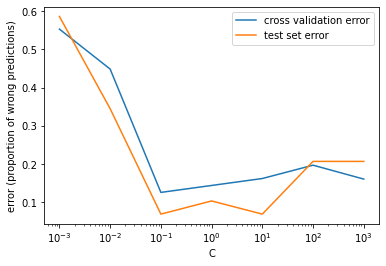

In [45]:
# Run cross validation using GridSearchCV

# Compute cross validation error
cv = GridSearchCV(estimator=lr, param_grid={'C': Cs})
cv.fit(xs_train, ys_train)
cverr = {cv.cv_results_['params'][i]['C']:1-cv.cv_results_['mean_test_score'][i] for i in range(len(cv.cv_results_['params']))}

# Compute test error
testerr = {C: 1-LogisticRegression(solver="liblinear", C=C).fit(xs_train, ys_train).score(xs_test, ys_test) for C in Cs}


# Plot results in new figure
fig, axis = plt.subplots(1)
axis.plot(cverr.keys(), cverr.values(), label="cross validation error")
axis.plot(testerr.keys(), testerr.values(), label="test set error")
plt.semilogx()
plt.ylabel("error (proportion of wrong predictions)")
plt.xlabel("C")
plt.legend()

print(f'cross validation error is minimal at {Cs[np.argmin(list(cverr.values()))]}')
print(f'test error is minimal at {Cs[np.argmin(list(testerr.values()))]}')


### Comment. Does CV choose the best C? How do different values of C compare with respect to over/underfitting?

Answer: cross validation error and test error agree on C = 0.1 as the optimal regularization strength. The two curves are largely parallel. There is no clear evidence of over-/underfitting.

### d) 

ROC AUC is maximal at 0.1
Recall is maximal at 0.001


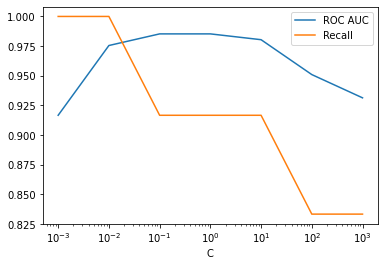

In [73]:
from sklearn.metrics import roc_curve, roc_auc_score, recall_score
# For each C compute the recall, auc and roc_curve
roc_auc = [roc_auc_score(ys_test, LogisticRegression(solver="liblinear", C=C).fit(xs_train, ys_train).predict_proba(xs_test)[:,1]) for C in Cs]
recall = [recall_score(ys_test, LogisticRegression(solver="liblinear", C=C).fit(xs_train, ys_train).predict(xs_test)) for C in Cs]
# Plot recall and AUC
fig, axis = plt.subplots(1)
axis.plot(Cs, roc_auc, label = "ROC AUC")
axis.plot(Cs, recall, label = "Recall")
plt.semilogx()
plt.xlabel("C")
plt.legend()

print(f'ROC AUC is maximal at {Cs[np.argmax(roc_auc)]}')
print(f'Recall is maximal at {Cs[np.argmax(recall)]}')


### e)

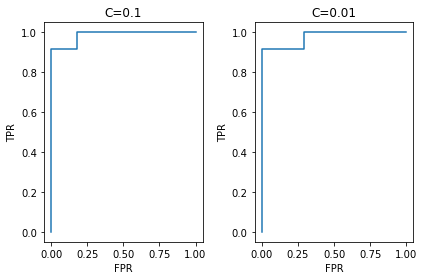

In [70]:
fpr1,tpr1,_ = roc_curve(ys_test, LogisticRegression(solver="liblinear", C=0.1).fit(xs_train, ys_train).predict_proba(xs_test)[:,1])
fpr2,tpr2,_ = roc_curve(ys_test, LogisticRegression(solver="liblinear", C=0.001).fit(xs_train, ys_train).predict_proba(xs_test)[:,1])

# Plot the roc_curve of the solutions that perform best in some criterion
fig, ax = plt.subplots(1,2)
ax[0].plot(fpr1,tpr1)
ax[0].set_title("C=0.1")
ax[0].set_xlabel("FPR")
ax[0].set_ylabel("TPR")
ax[1].plot(fpr2,tpr2)
ax[1].set_title("C=0.001")
ax[1].set_xlabel("FPR")
ax[1].set_ylabel("TPR")
plt.tight_layout()

### Name 3 desired properties of a classifier; for each of these decide which value of $C$ you would choose.

Answer: Low test set error (C = 0.1); High ROC AUC (C = 0.1); High Recall (C = 0.001)

### (f) Which cardinal crime have we just committed in (e)?

Answer: chosen hyperparameters after looking at the test set, rather than choosing them based on the cross validation results

## Exercise 2